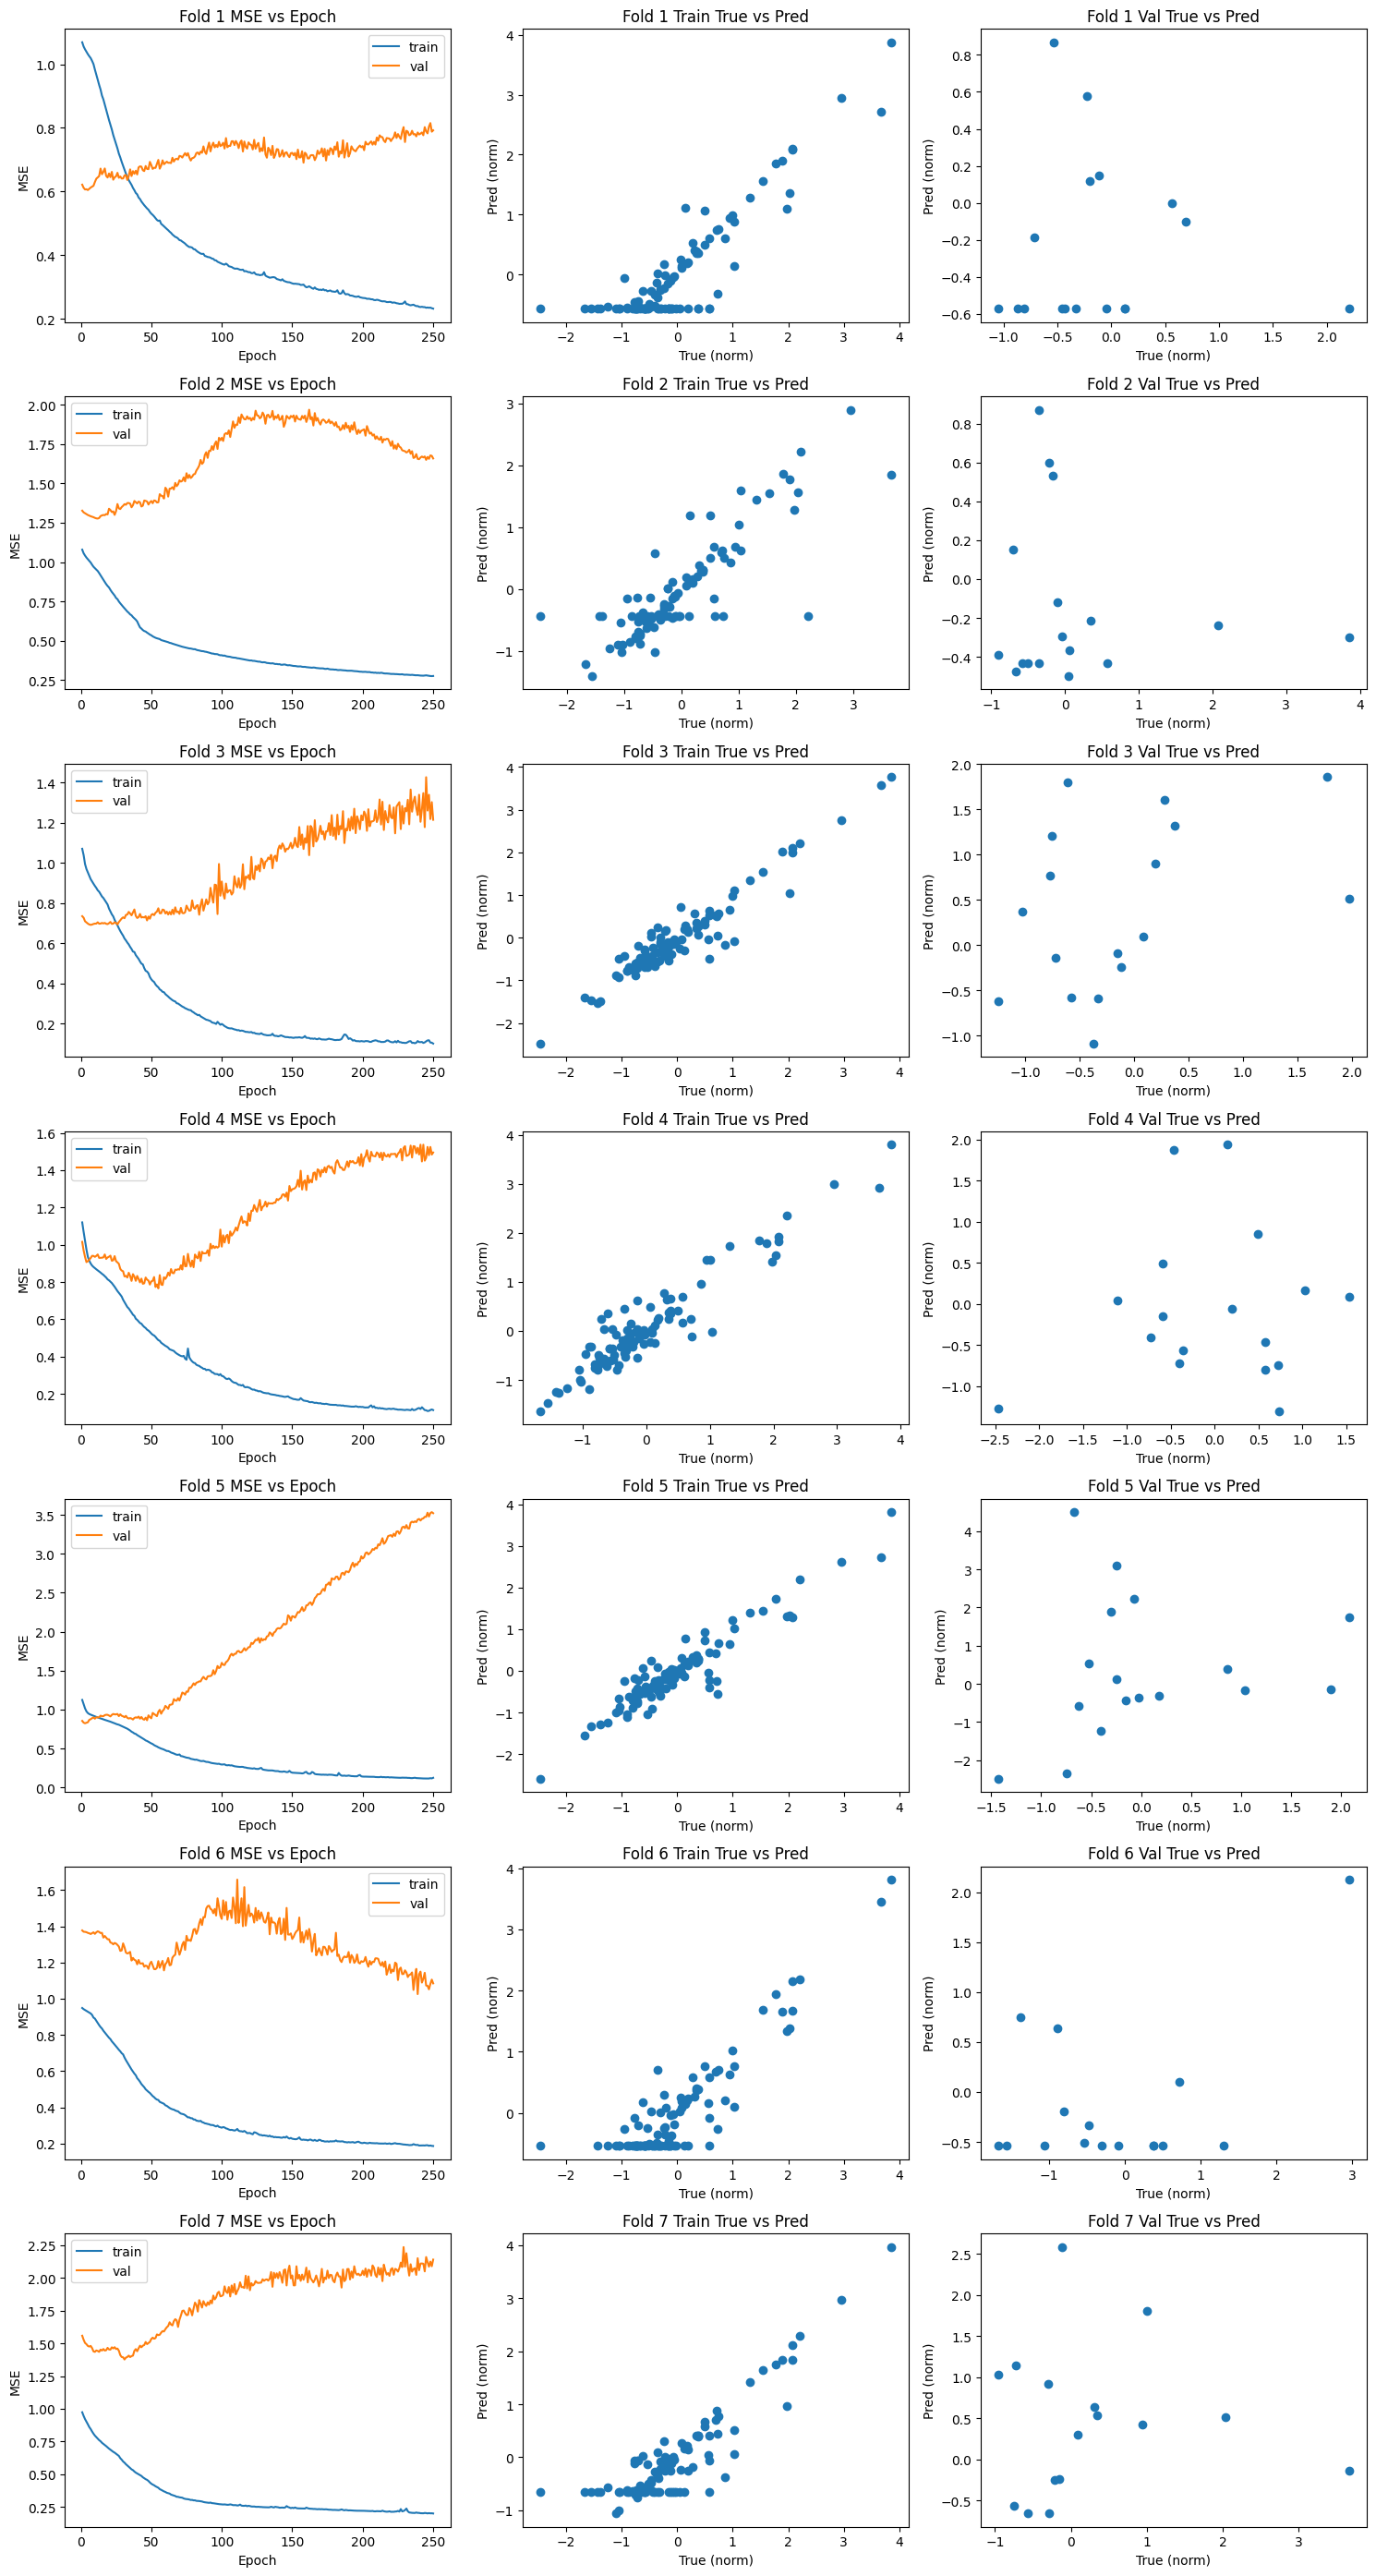

In [24]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fixed categorical map for Inputs 1–7
categories_map = {
    'Input 1': [1, 2],
    'Input 2': [1, 2],
    'Input 3': [1, 2, 3],
    'Input 4': [1, 2],
    'Input 5': [1, 2, 3],
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
}

# Fixed list of real-valued inputs for normalization (Inputs 8–14)
numeric_inputs = [f"Input {i}" for i in range(8, 15)]  # Inputs 8–14

def cross_validate_nn_with_history(
    csv_path: str,
    use_inputs: list[bool],
    k_folds: int,
    layer_dims: list[int],
    activations: list[str],
    epochs: int,
    learning_rate: float,
    batch_size: int,
    device: str,
    random_state: int
):
    # Load and preprocess
    df = pd.read_csv(csv_path)
    all_inputs = [f"Input {i}" for i in range(1, 15)]
    selected = [col for col, use in zip(all_inputs, use_inputs) if use]
    X = df[selected].copy()
    y_np = df['output'].to_numpy(dtype=np.float32).reshape(-1, 1)
    y_mean = y_np.mean()
    y_std = y_np.std() if y_np.std() != 0 else 1.0
    y = (y_np - y_mean) / y_std

    # Encode categoricals
    for col, cats in categories_map.items():
        if col not in X.columns:
            continue
        if len(cats) == 2:
            X[col] = X[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            X[col] = pd.Categorical(X[col], categories=cats)
            dummies = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                name = f"{col}_{c}"
                if name not in dummies:
                    dummies[name] = 0
            X = pd.concat([X.drop(col, axis=1), dummies], axis=1)

    # Normalize numeric inputs
    means = X[numeric_inputs].mean()
    stds = X[numeric_inputs].std().replace(0, 1.0)
    X[numeric_inputs] = (X[numeric_inputs] - means) / stds

    X_np = X.to_numpy(dtype=np.float32)

    # Prepare CV
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results = []

    # Loop folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np), 1):
        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        # Build model
        layers = []
        in_dim = X_train.shape[1]
        for dim, act in zip(layer_dims, activations):
            layers.append(nn.Linear(in_dim, dim))
            a = act.lower()
            if a == 'relu':
                layers.append(nn.ReLU())
            elif a == 'tanh':
                layers.append(nn.Tanh())
            elif a == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif a == 'softplus':
                layers.append(nn.Softplus())
            else:
                raise ValueError(f"Unsupported activation: {act}")
            in_dim = dim
        layers.append(nn.Linear(in_dim, 1))
        model = nn.Sequential(*layers).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Prepare full-set tensors
        X_train_t = torch.from_numpy(X_train).to(device)
        X_val_t = torch.from_numpy(X_val).to(device)

        train_losses = []
        val_losses = []

        # Train with history
        for epoch in range(1, epochs + 1):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

            # Record full-set MSE
            model.eval()
            with torch.no_grad():
                train_pred = model(X_train_t).cpu().numpy()
                val_pred = model(X_val_t).cpu().numpy()
            train_losses.append(mean_squared_error(y_train, train_pred))
            val_losses.append(mean_squared_error(y_val, val_pred))

        # Store results
        fold_results.append({
            'fold': fold,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_preds': train_pred.flatten(),
            'train_targets': y_train.flatten(),
            'val_preds': val_pred.flatten(),
            'val_targets': y_val.flatten()
        })

    return fold_results, y_mean, y_std

# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 4]
activations = ['relu', 'relu']
epochs = 250
learning_rate = 2e-3
batch_size = 8
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


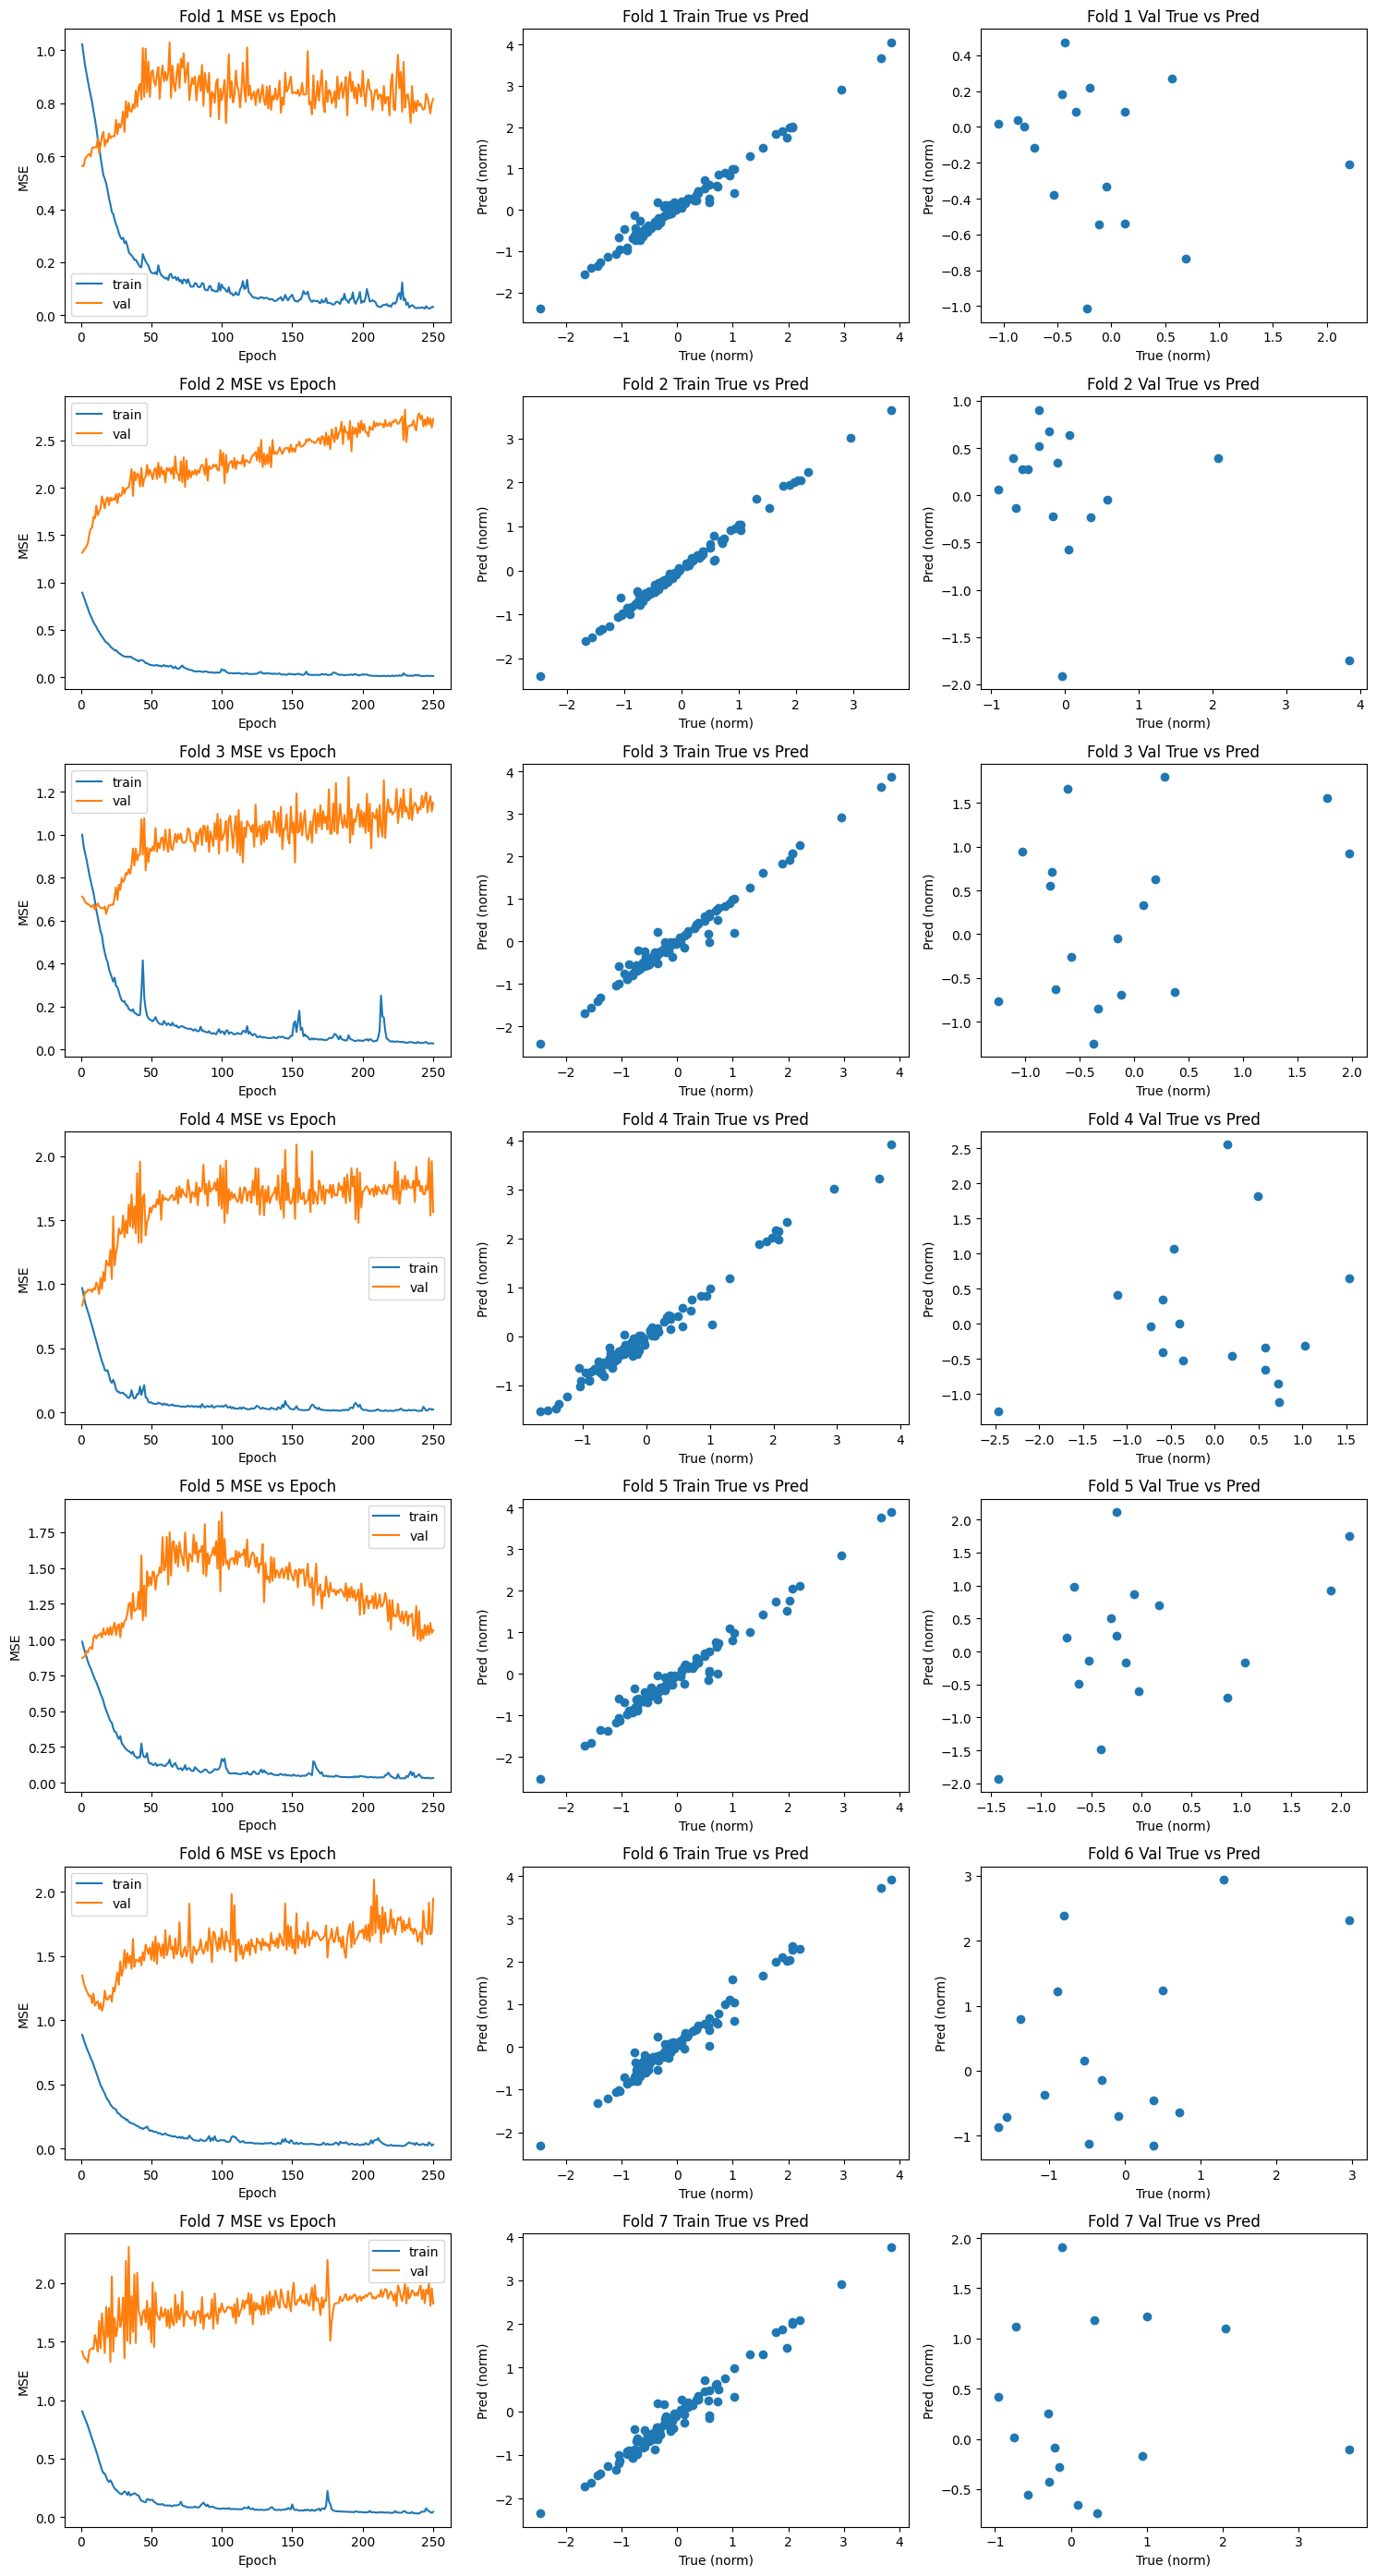

In [25]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [64, 16]
activations = ['relu', 'relu']
epochs = 250
learning_rate = 2e-3
batch_size = 8
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


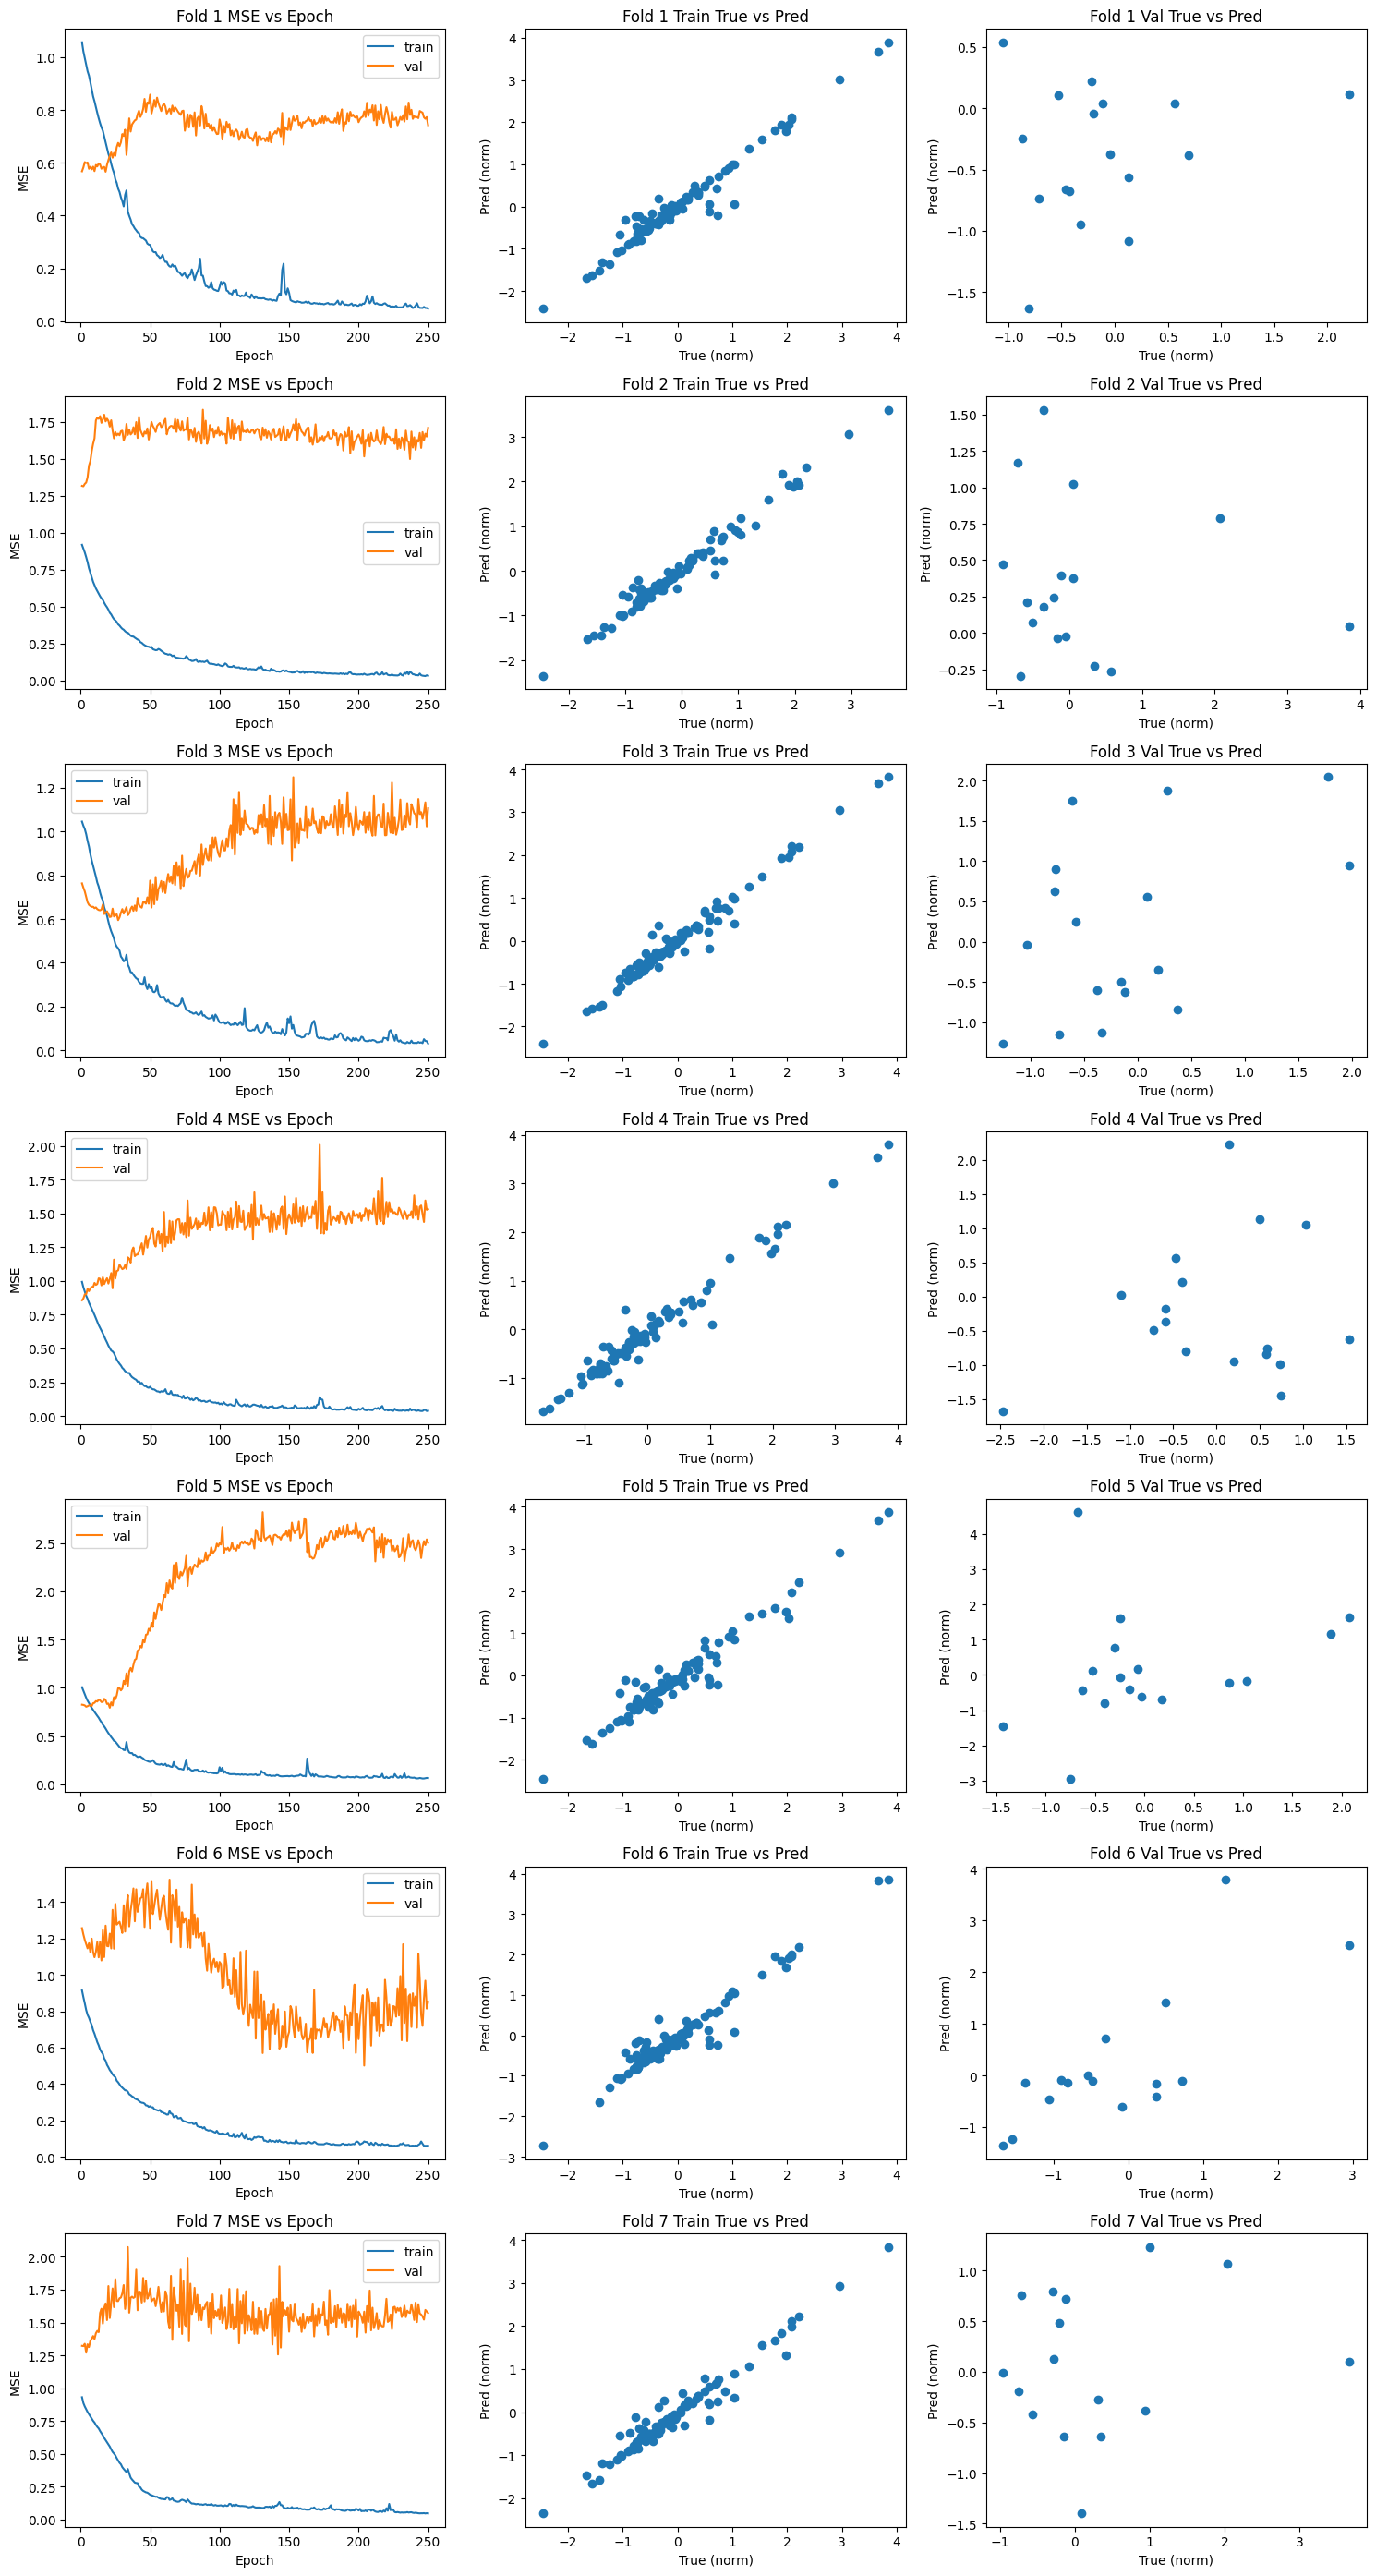

In [26]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [16, 16]
activations = ['relu', 'relu']
epochs = 250
learning_rate = 2e-3
batch_size = 6
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


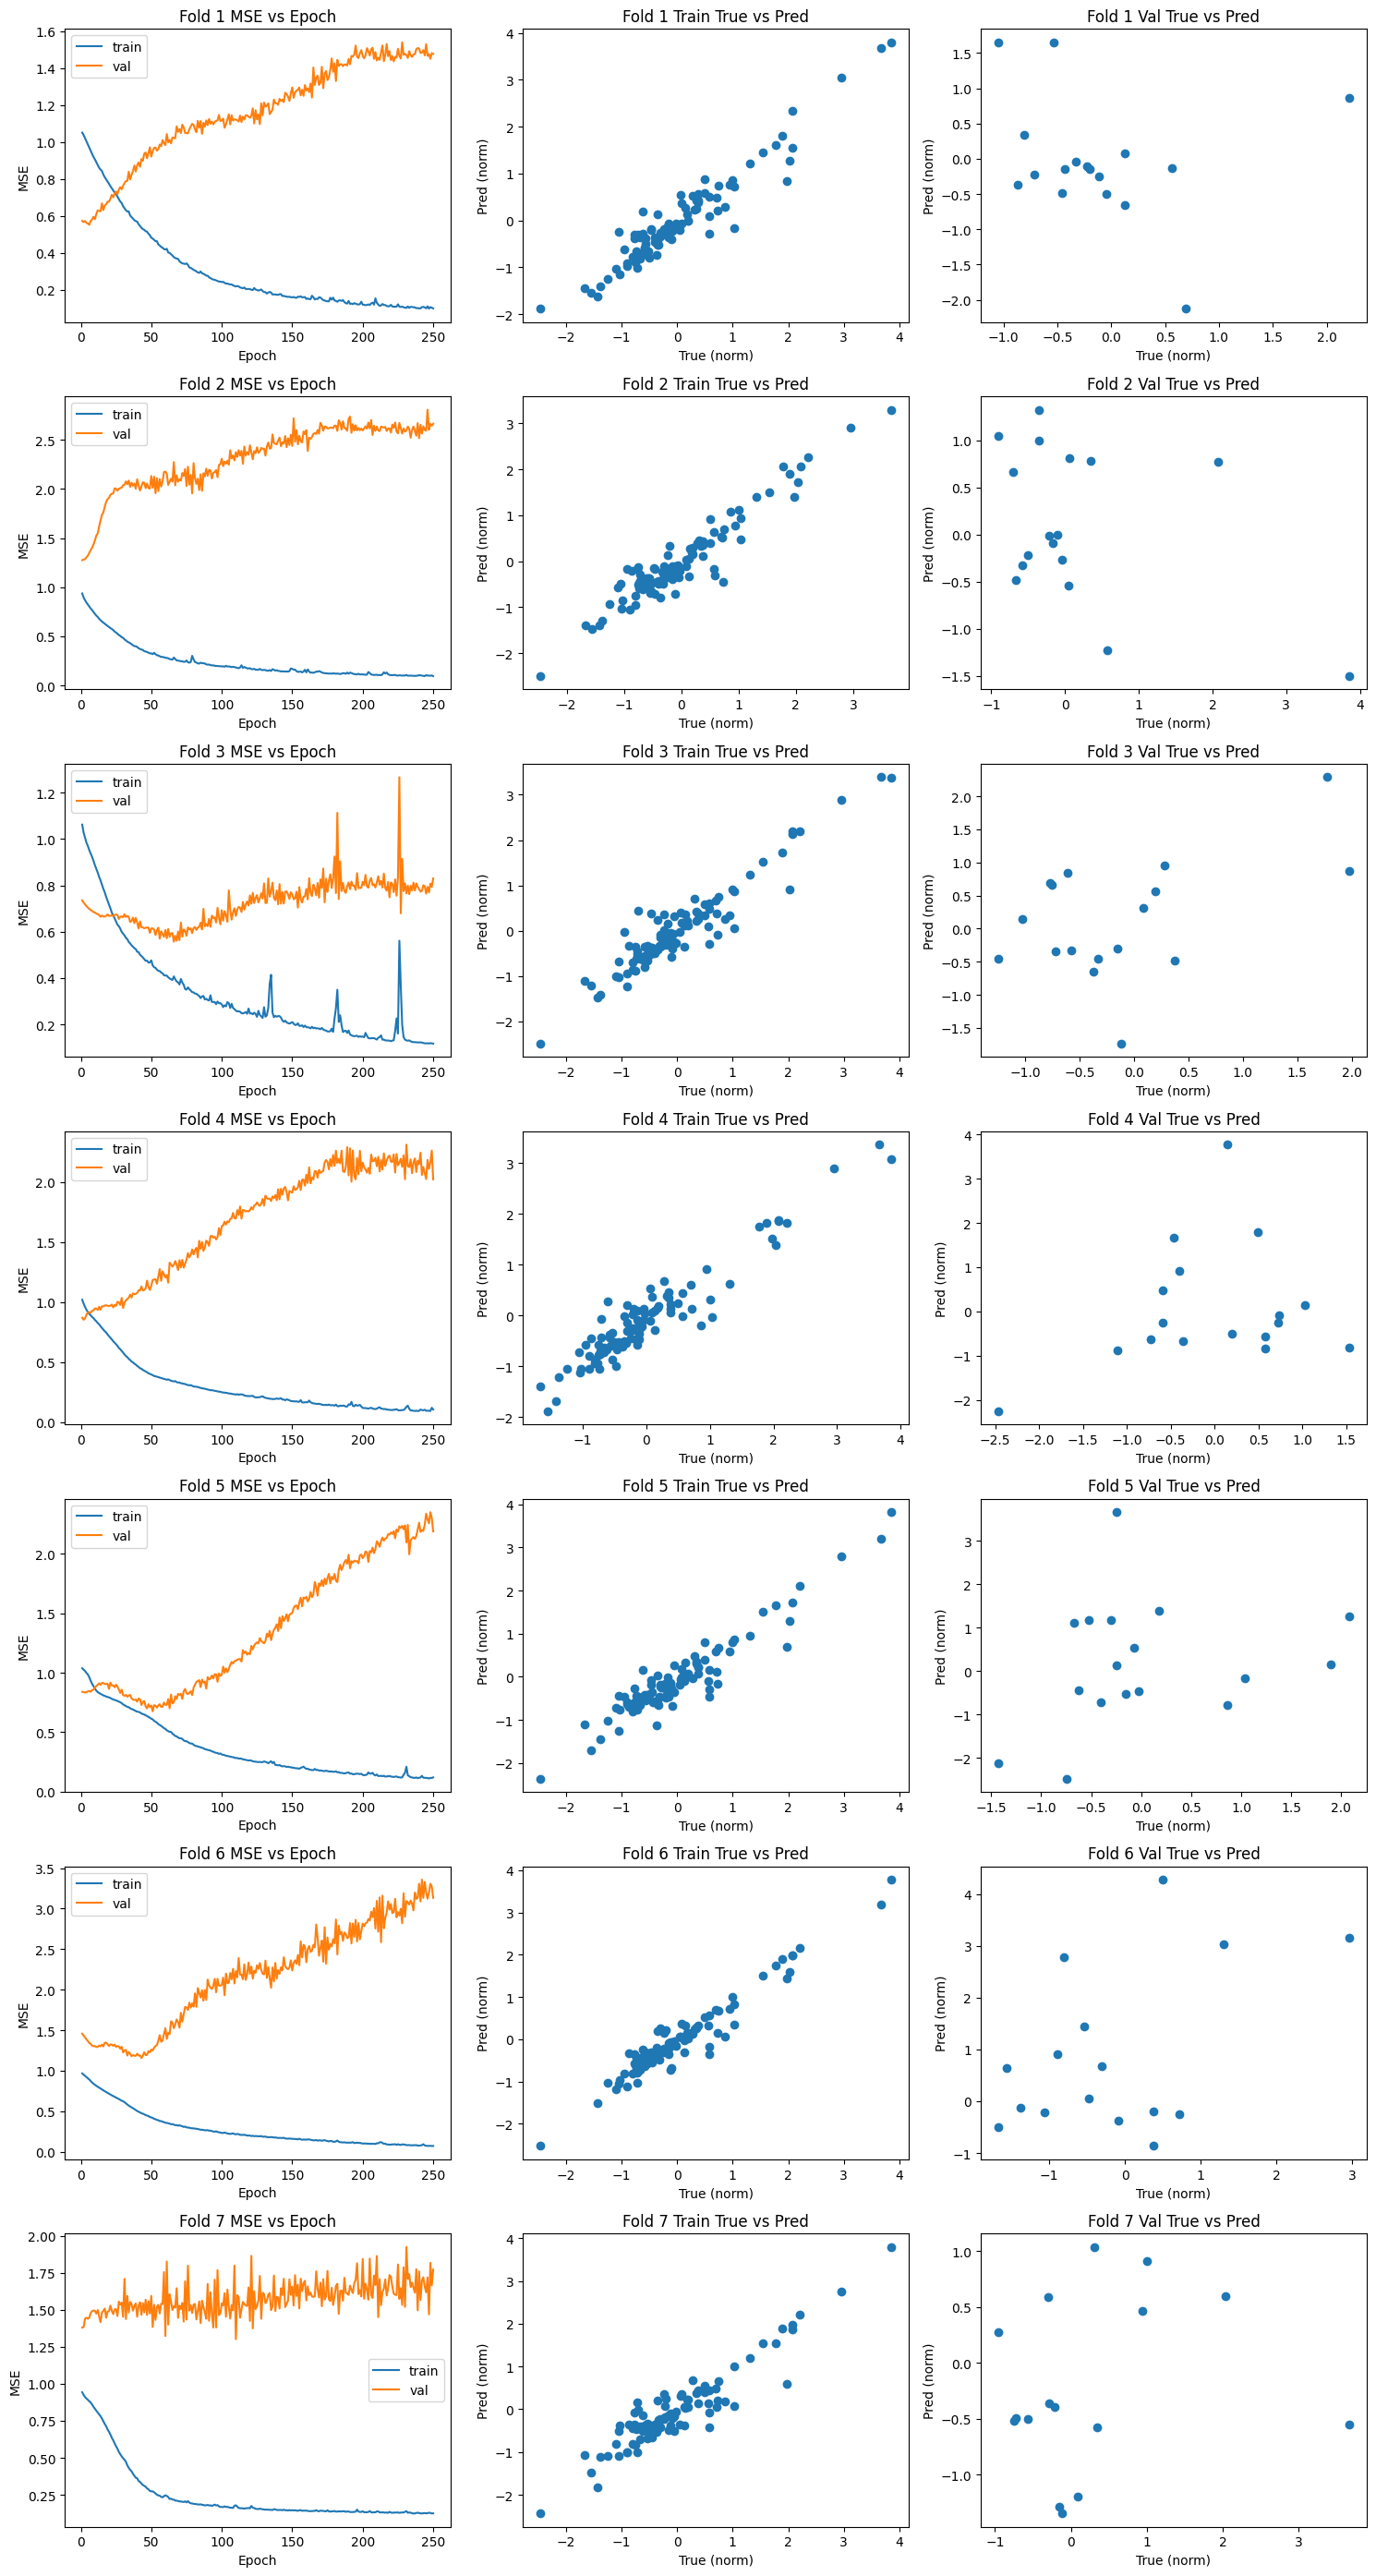

In [27]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 8]
activations = ['relu', 'relu']
epochs = 250
learning_rate = 2e-3
batch_size = 6
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


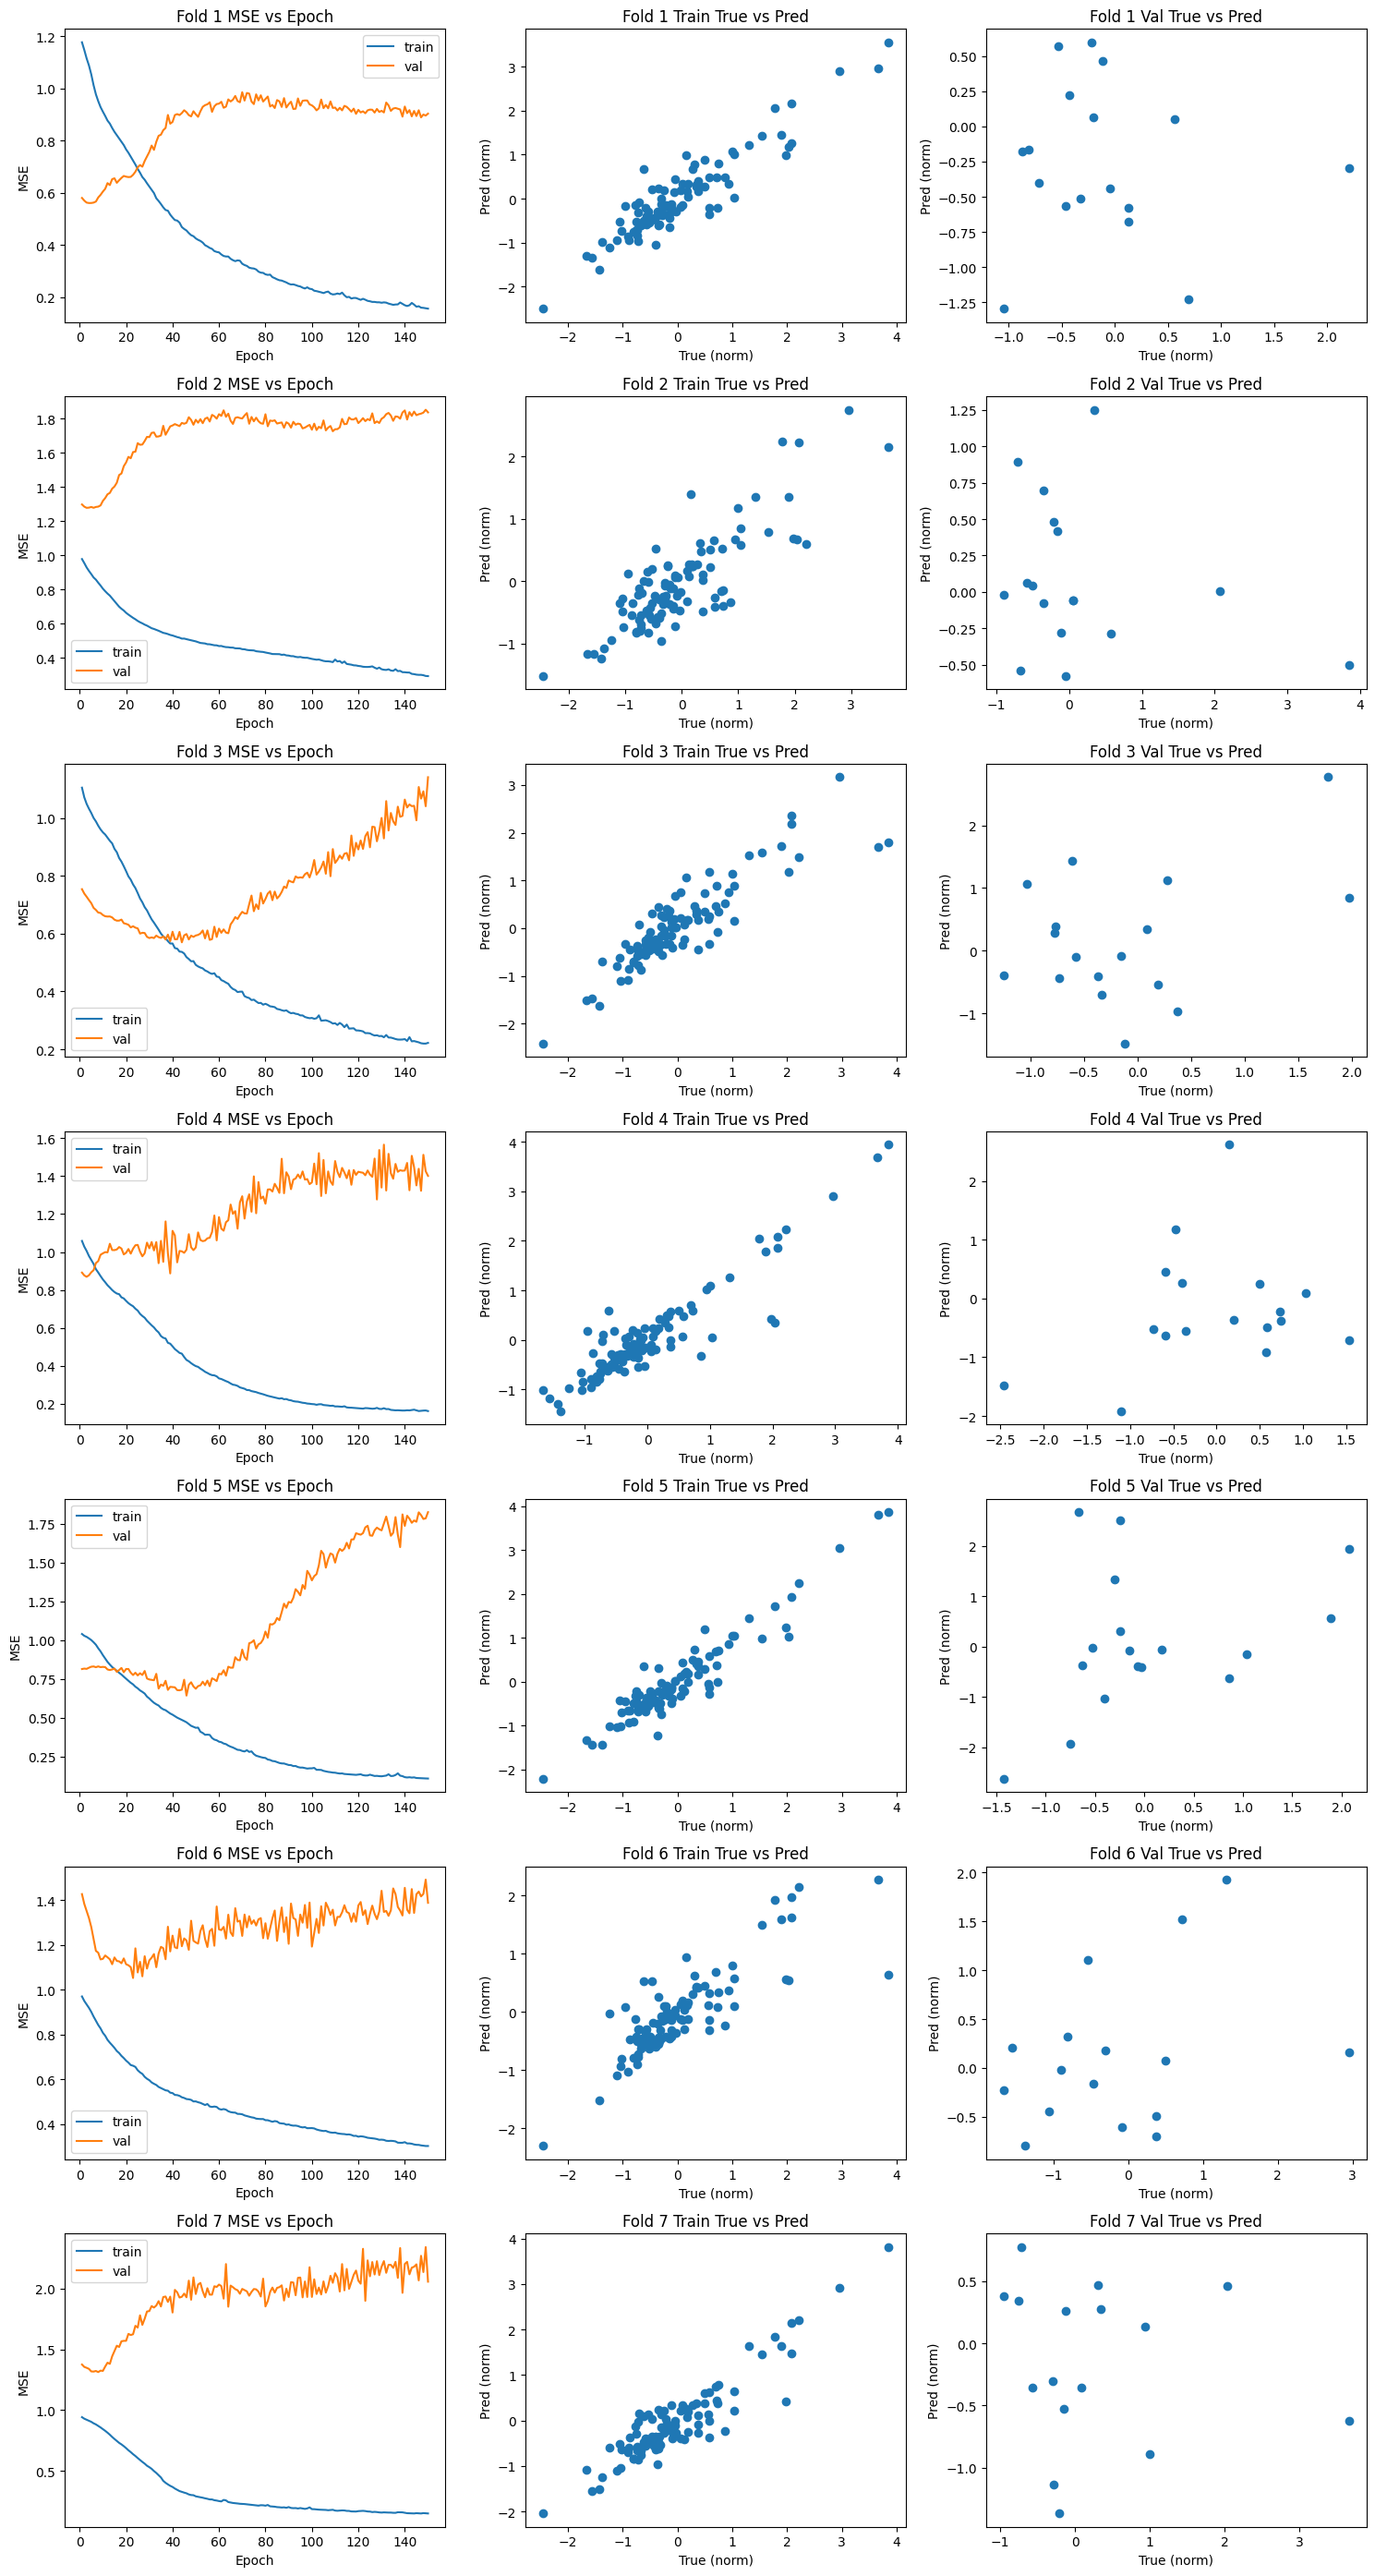

In [28]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 8]
activations = ['relu', 'relu']
epochs = 150
learning_rate = 2e-3
batch_size = 6
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


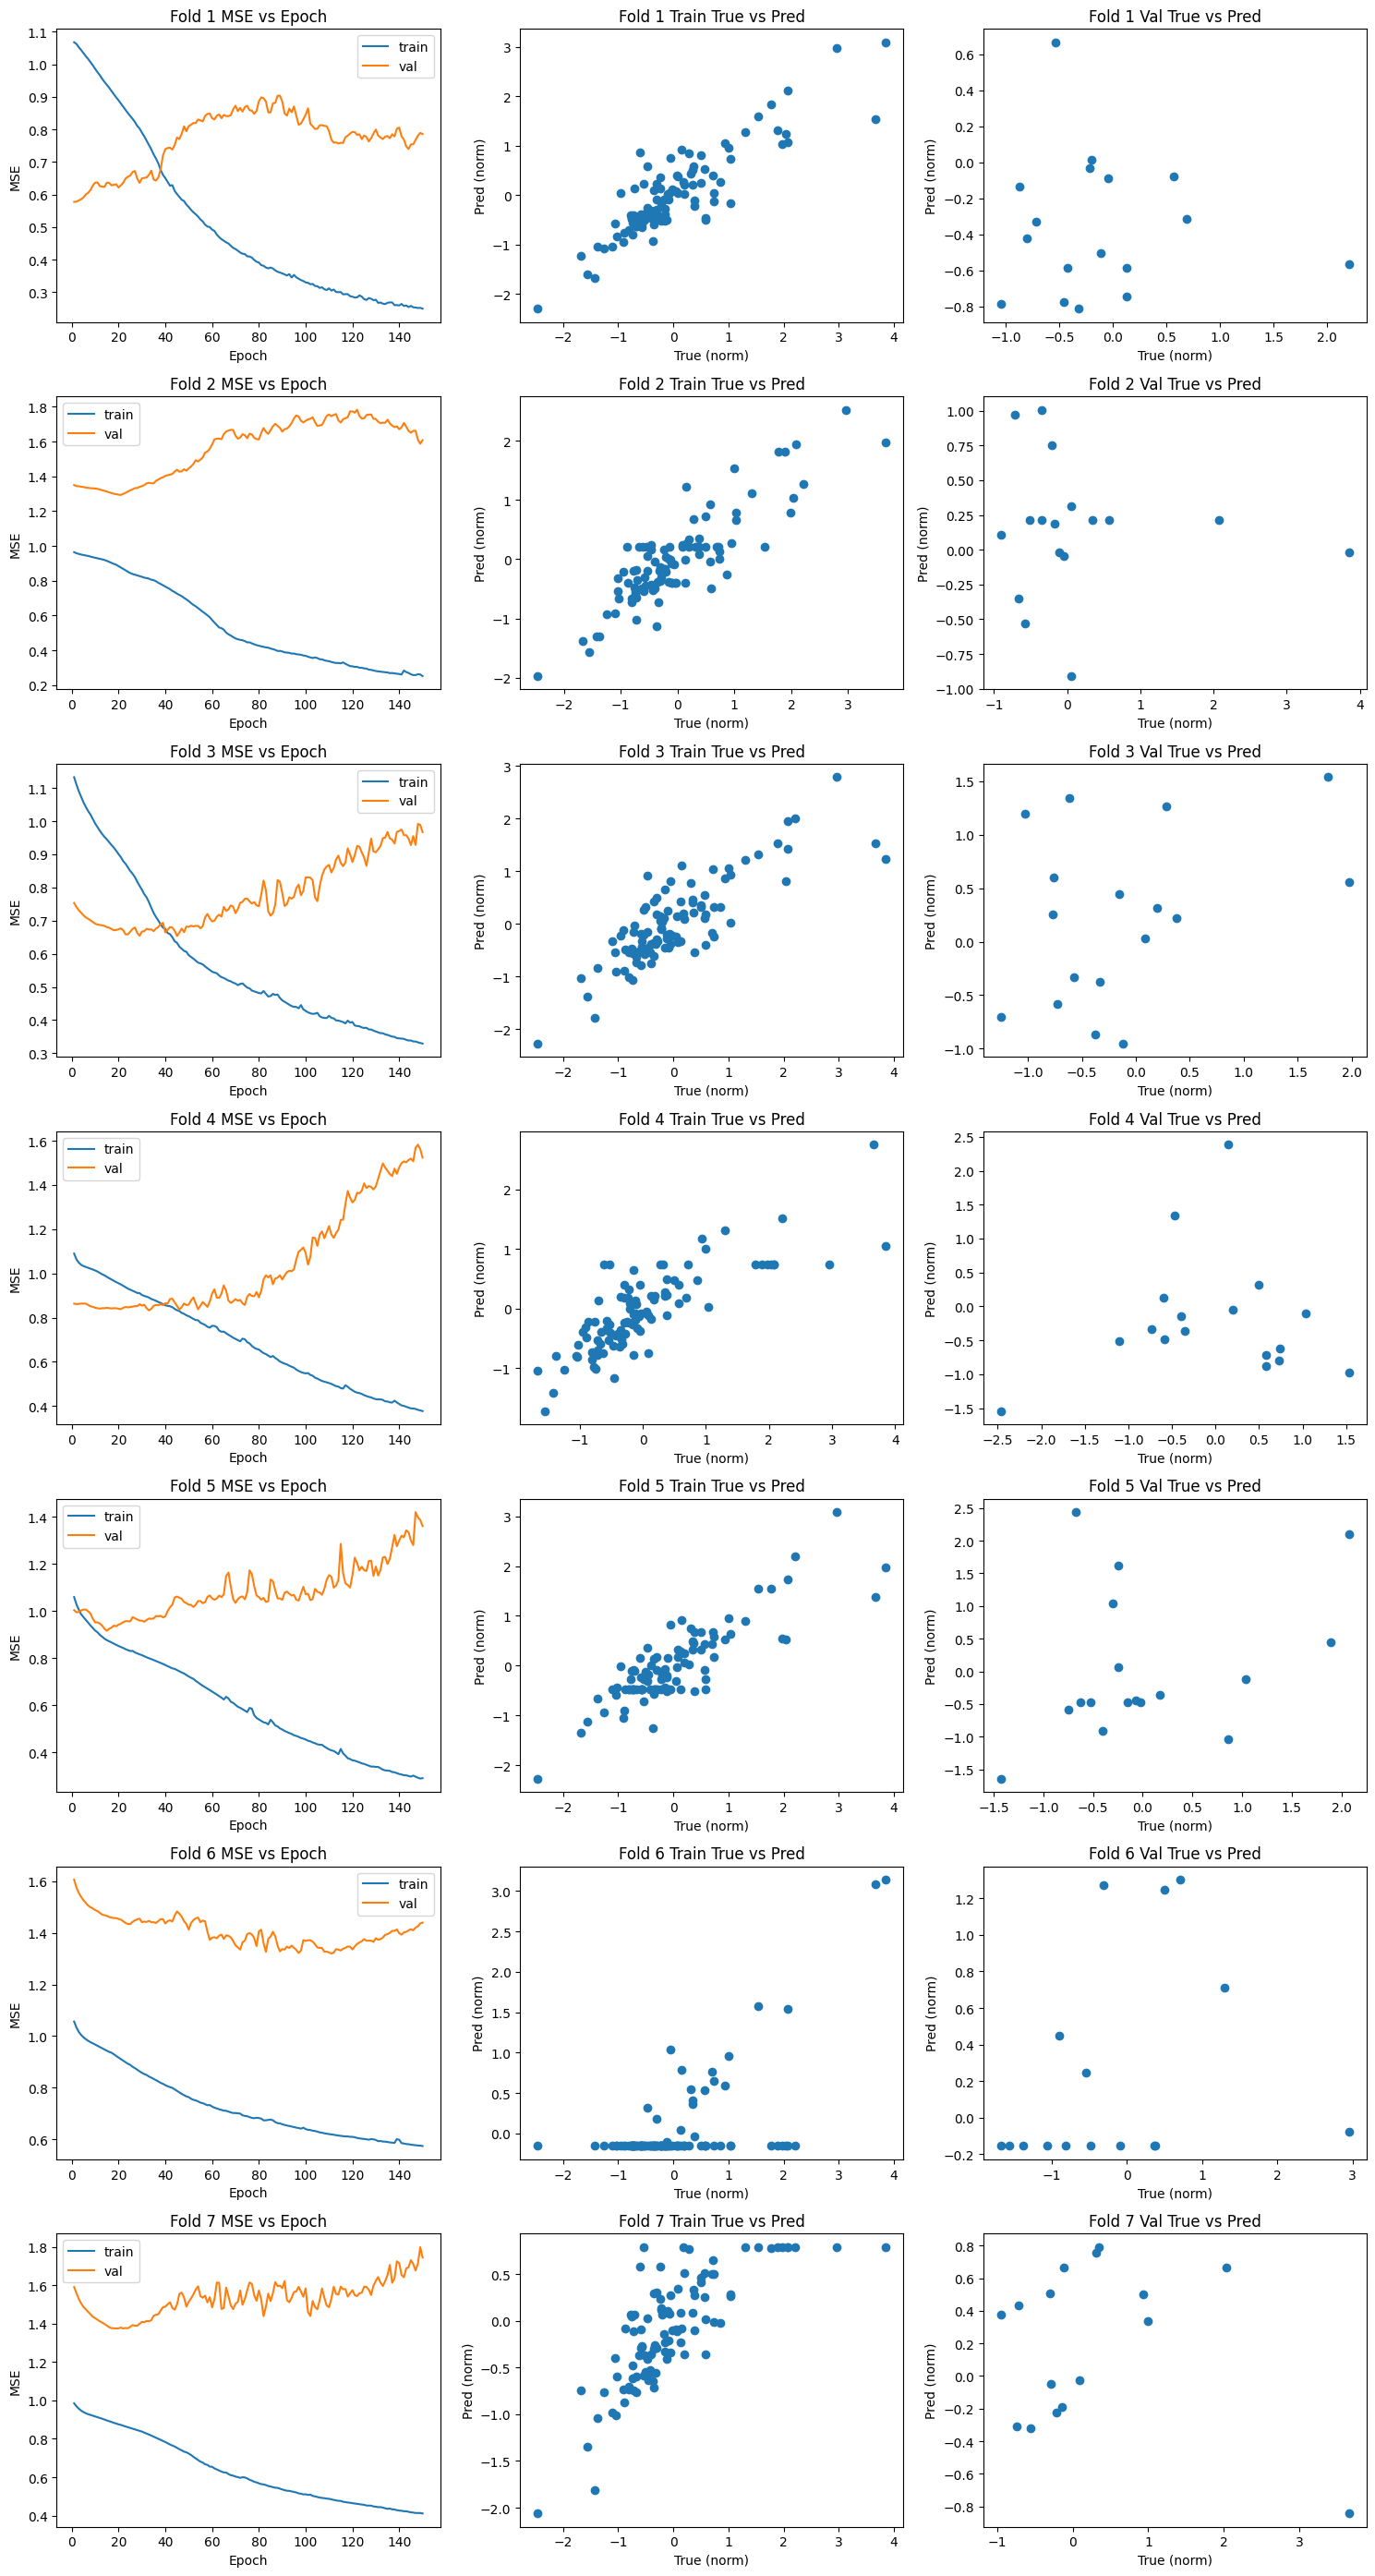

In [29]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 4]
activations = ['relu', 'relu']
epochs = 150
learning_rate = 2e-3
batch_size = 16
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


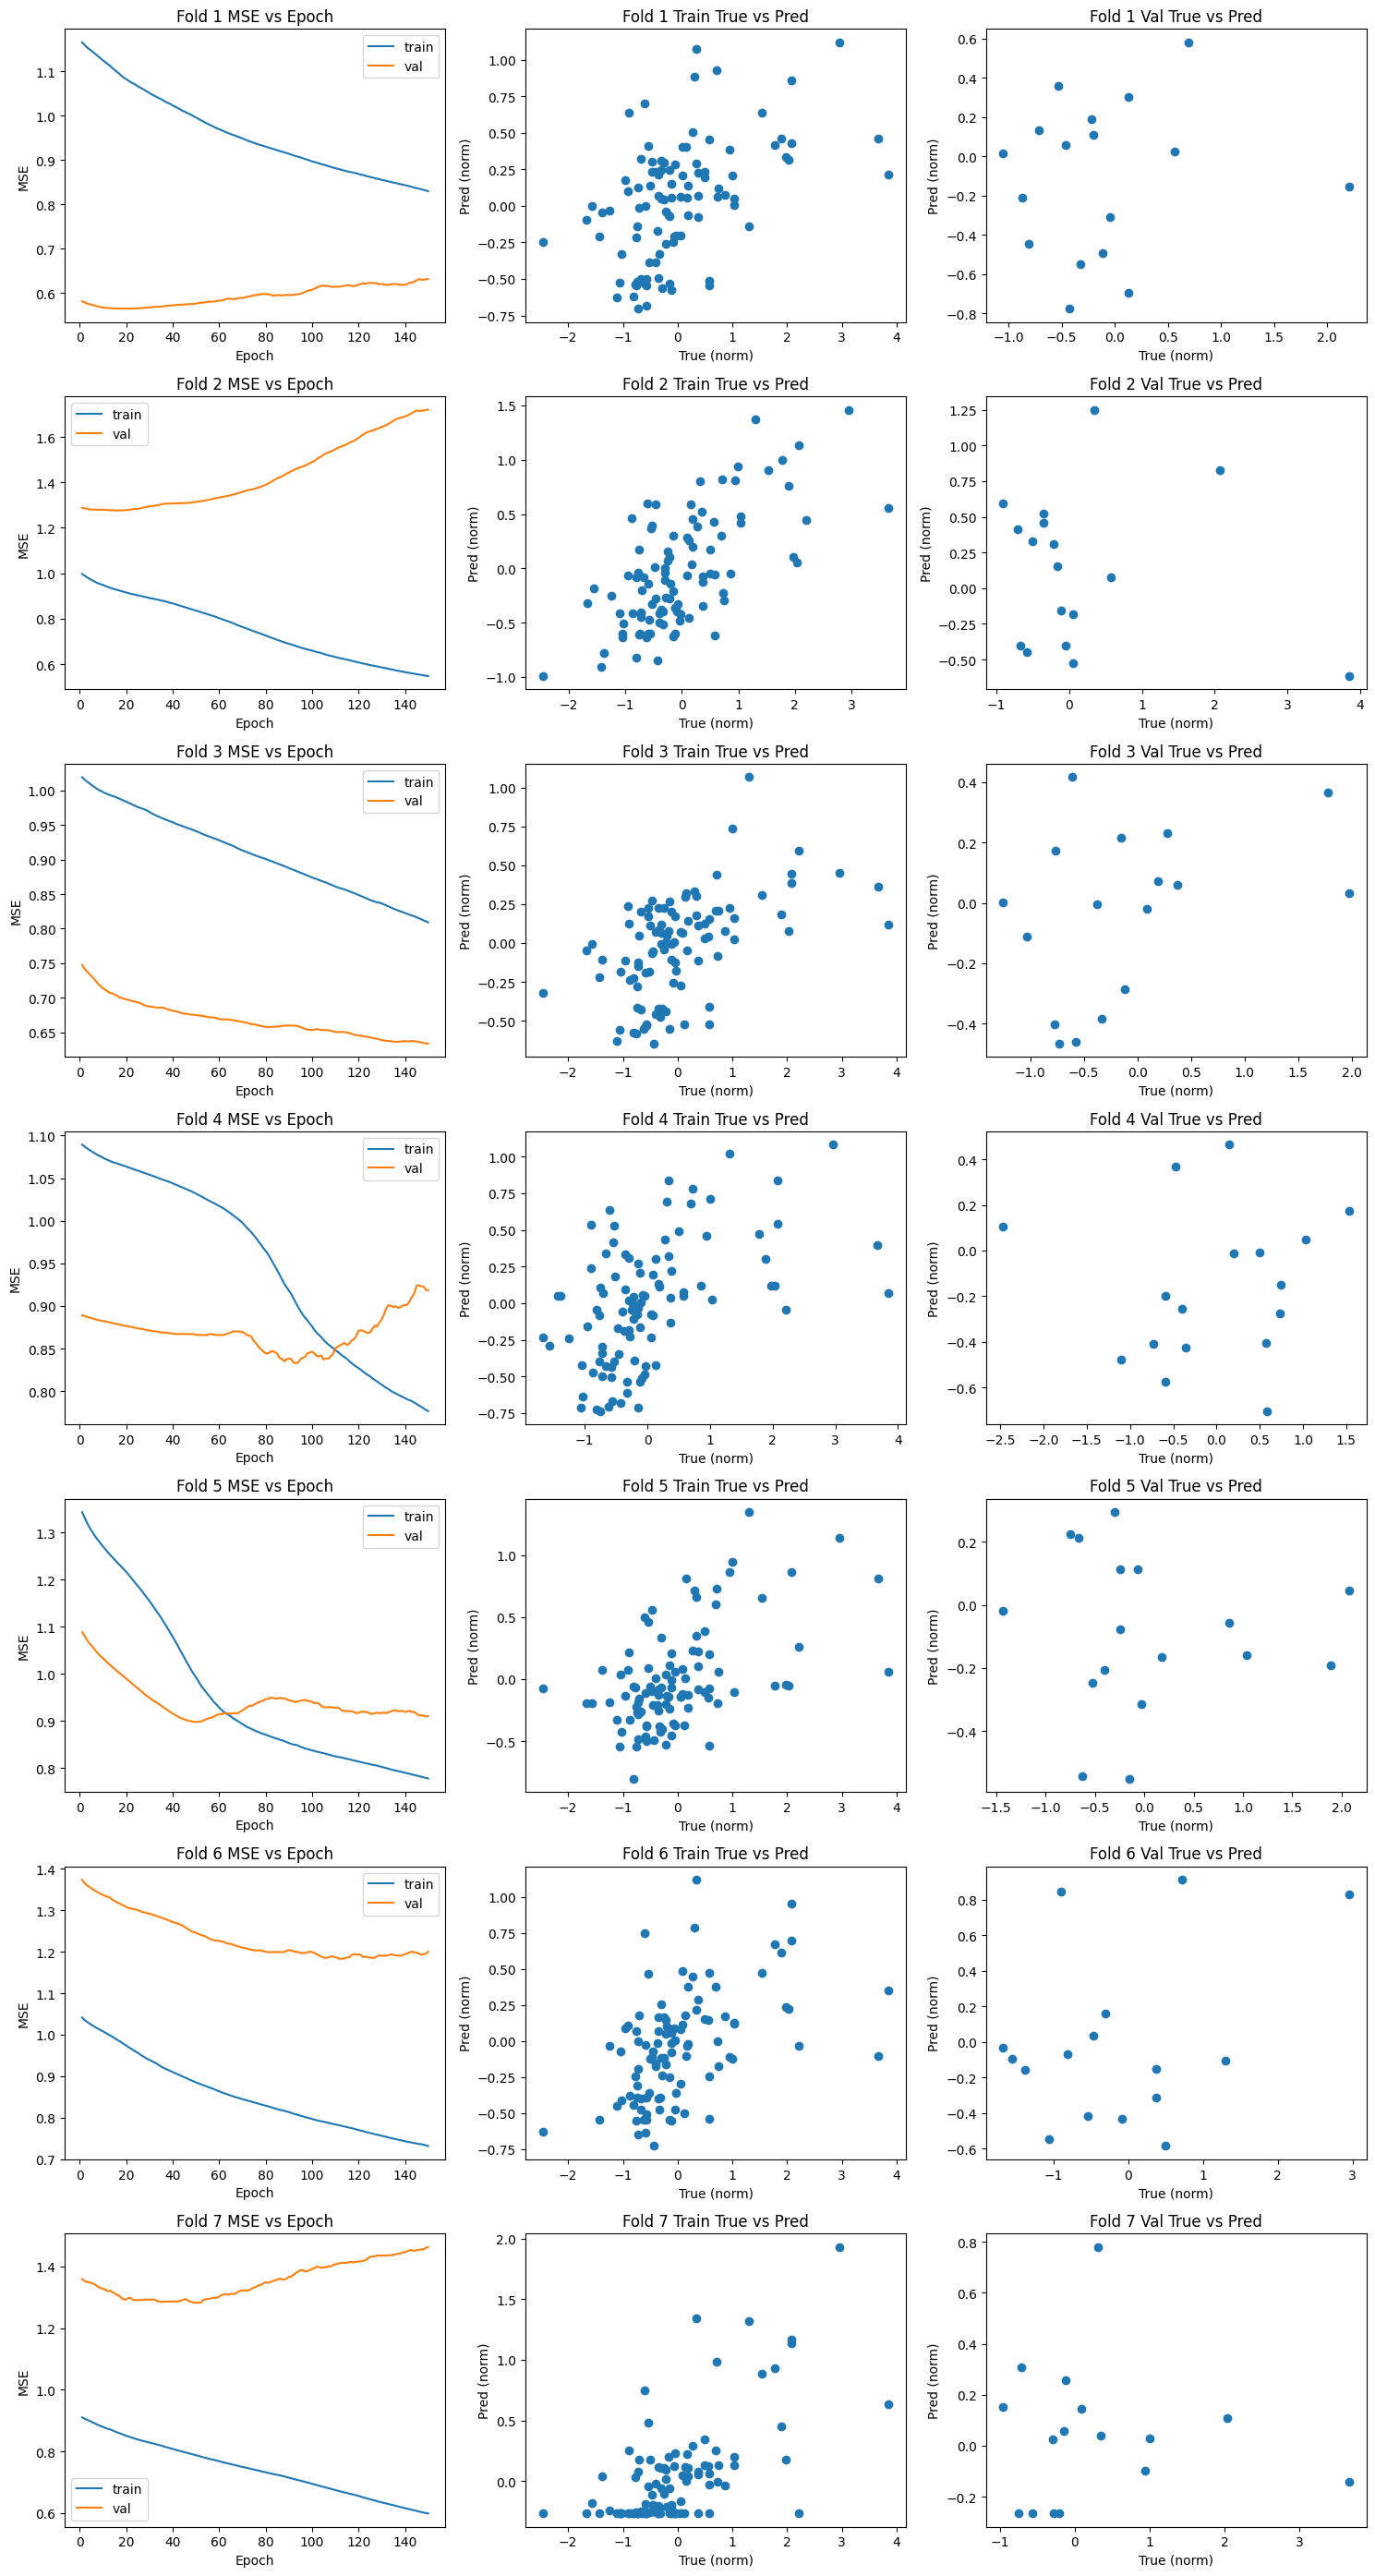

In [30]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 4]
activations = ['relu', 'relu']
epochs = 150
learning_rate = 0.5e-3
batch_size = 16
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()


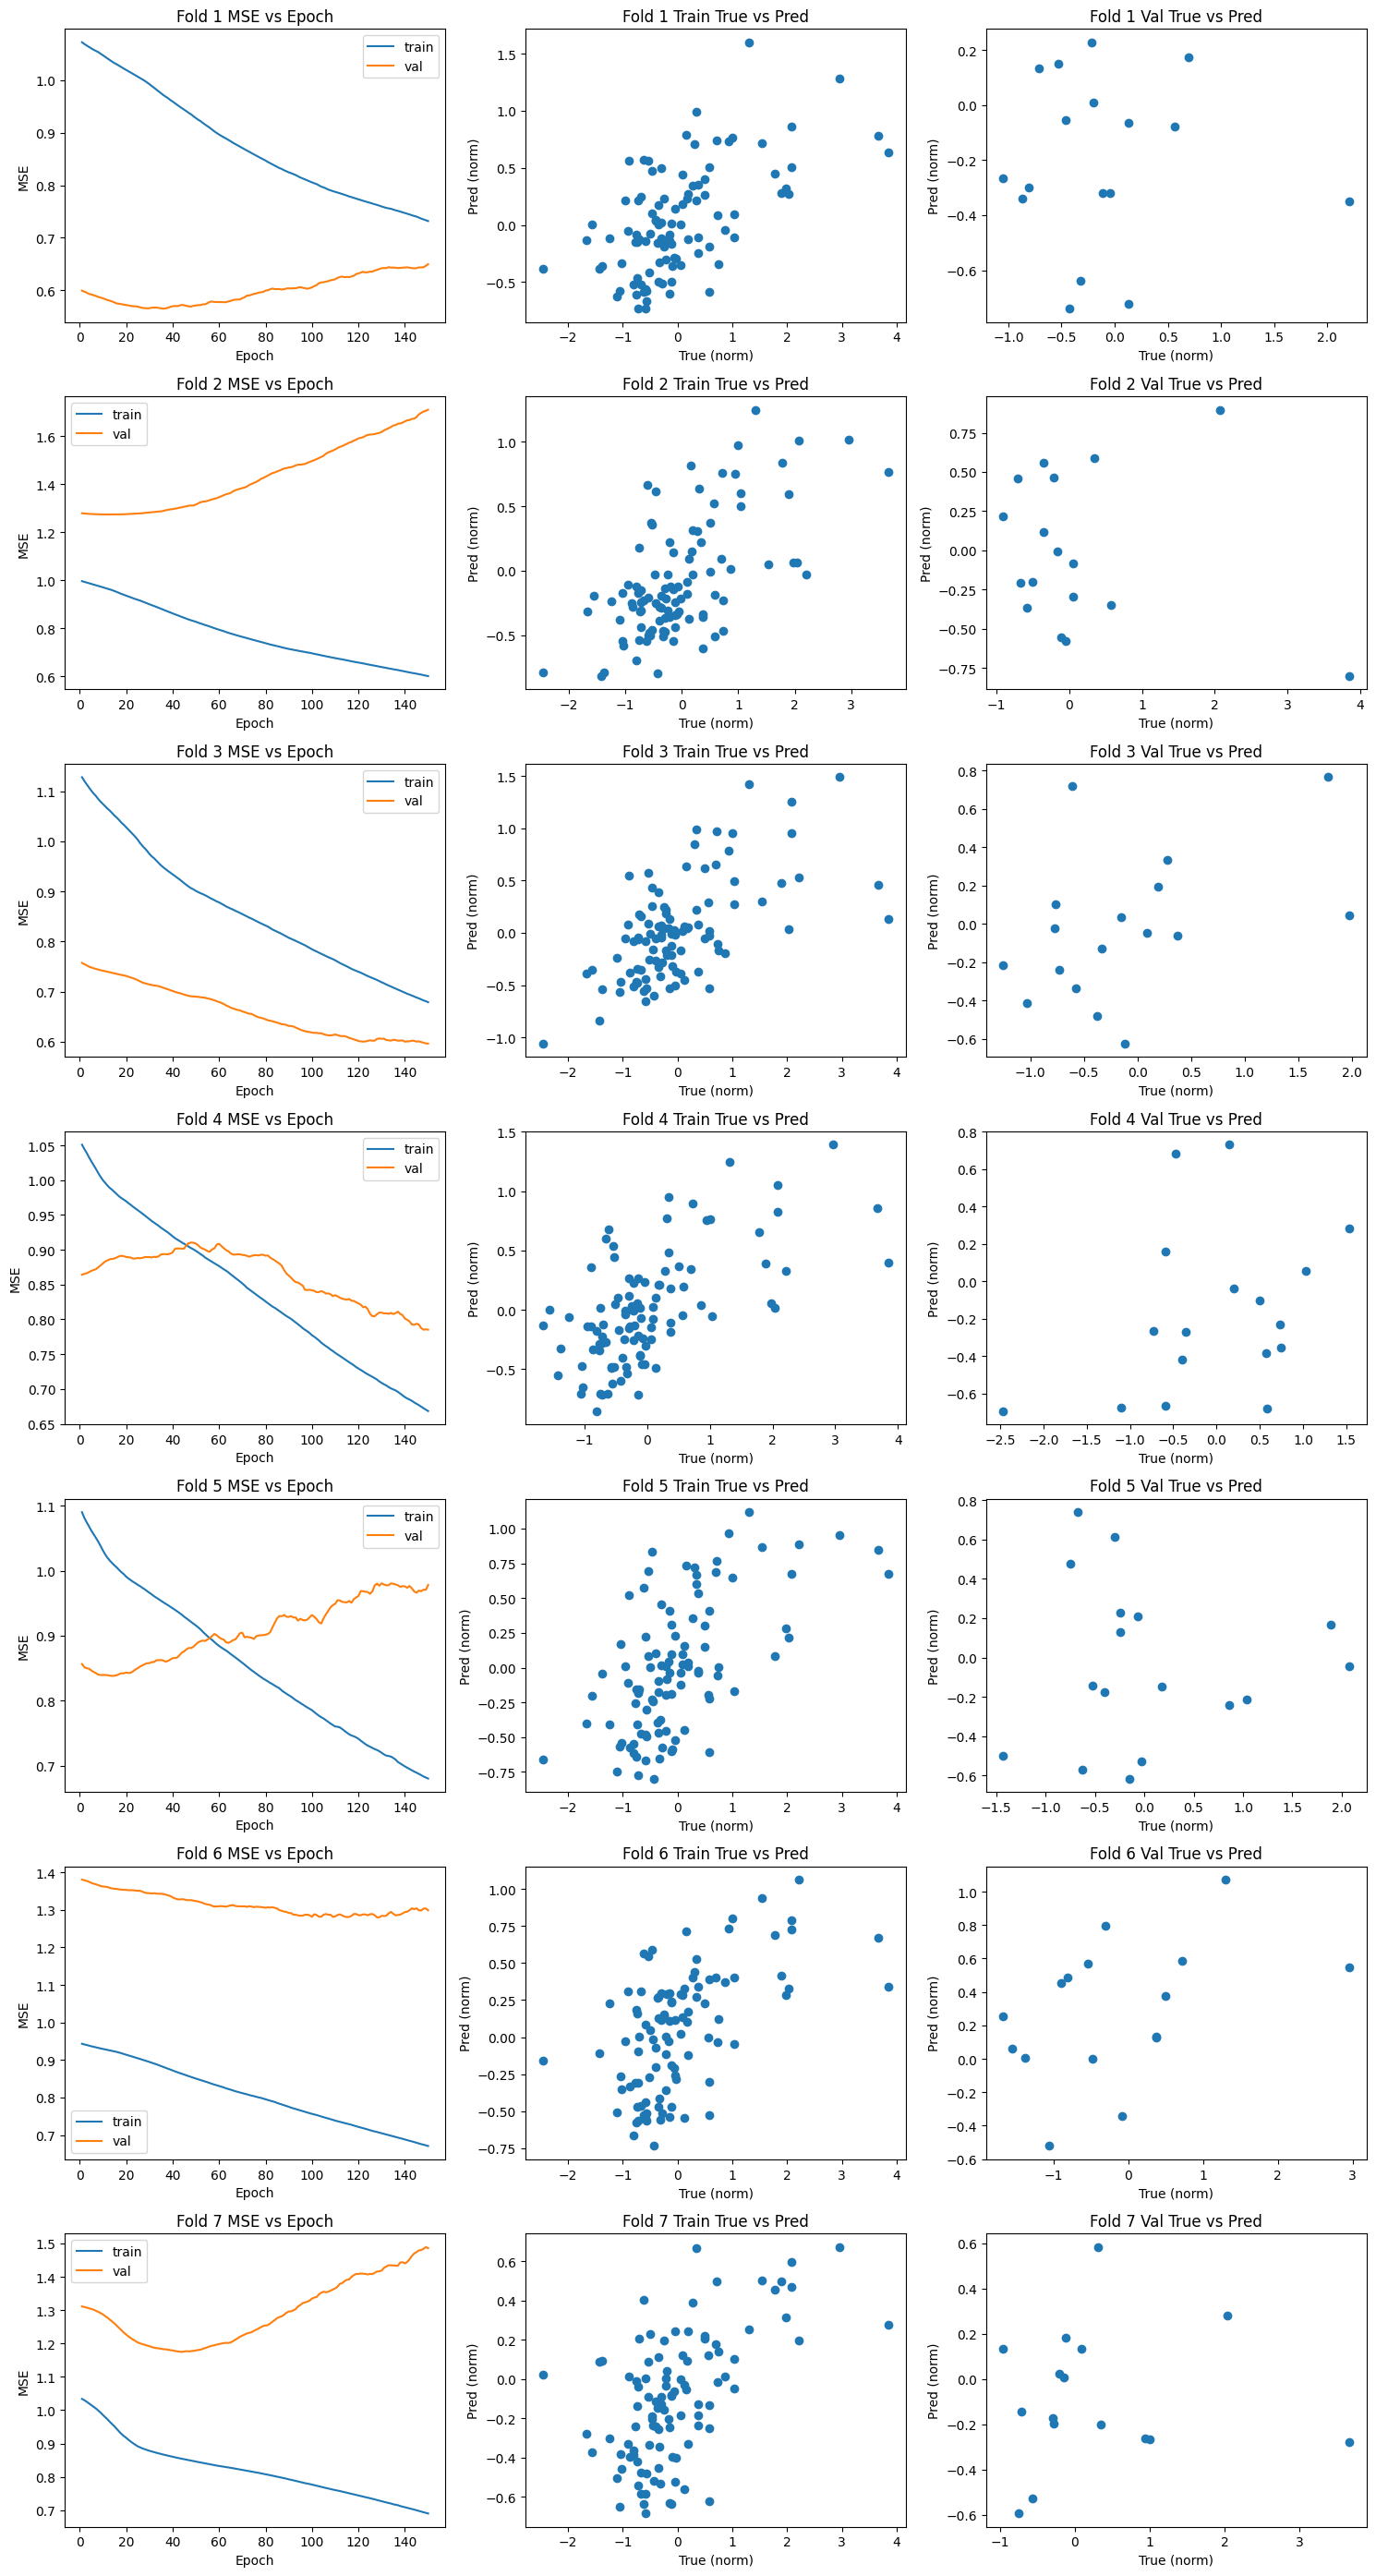

In [31]:
# Parameters
use_inputs = [True]*14
k_folds = 7
layer_dims = [8, 8]
activations = ['relu', 'relu']
epochs = 150
learning_rate = 0.5e-3
batch_size = 16
device = 'cpu'  # force CPU to avoid NCCL issues
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/train_val.csv'
random_state = 42

# Run CV and get history
fold_results, y_mean, y_std = cross_validate_nn_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations,
    epochs, learning_rate,
    batch_size, device, random_state
)

# Plotting all folds in subplots
fig, axes = plt.subplots(k_folds, 3, figsize=(15, k_folds * 4))

for i, res in enumerate(fold_results):
    epochs_range = range(1, epochs + 1)
    ax1, ax2, ax3 = axes[i]

    # MSE vs Epoch
    ax1.plot(epochs_range, res['train_losses'], label='train')
    ax1.plot(epochs_range, res['val_losses'], label='val')
    ax1.set_title(f'Fold {res["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.legend()

    # Train scatter
    ax2.scatter(res['train_targets'], res['train_preds'])
    ax2.set_title(f'Fold {res["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)')
    ax2.set_ylabel('Pred (norm)')

    # Val scatter
    ax3.scatter(res['val_targets'], res['val_preds'])
    ax3.set_title(f'Fold {res["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)')
    ax3.set_ylabel('Pred (norm)')

plt.tight_layout()
plt.show()
